In [11]:
import numpy as np
import matplotlib.pyplot as plt
import random
from math import *
import time

In [12]:
def GeneratorCity(nb_city: int = 10, size_map: tuple = (100, 100)) -> list:
    """
    Return a list of cities with random coordinates and their utility

    Arguments:
        nb_city: Number of cities
        size_map: Area of the map in this format : (max_abscissa, max_ordinate)
        display: Draw a diagram of the situation

    Return:
        An array of cities with the abscissa, ordinate and the use of each cities ;
        0 means "This city is not important" ;
        1 means "This city must be delivered" ;
        2 means "This city is the depository" ;
    """

    # Randomization of points
    abscissa = random.sample(range(0, size_map[0]), nb_city)
    ordinate = random.sample(range(0, size_map[1]), nb_city)

    # Return the list of coordinate
    return [[abscissa[i],ordinate[i]] for i in range(nb_city)]


def DefinitionCity(cities: list) -> list:
    """
    Defines the type of cities

    Arguments:
        cities: The cities
        only_delivered: Removal of undelivered cities

    Return:
        The list of cities
    """

    # Define the kind of city
    delivered = random.choices(population=[0, 1], k=len(cities))

    # Define a repository
    delivered[random.randint(1, len(cities)) - 1] = 2

    # Return the list of city
    return [[cities[i][0],cities[i][1],delivered[i]] for i in range(len(cities))]


def GeneratorGraph(cities: list, fluctuation: int = 10, fluctuation_weight: int = 10):
    """
    Return the graph of the instance

    Arguments:
        cities: The coordinate from the city in this format : [max_abscissa, max_ordinate]
        fluctuation: The rate of fluctuation of the cost of the arcs
        fluctuation_weight: The fluctuation amplitude of the cost of the arcs

    Return:
        A matrix of size [nb_city, nb_city, 3]
    """

    # Initialization of the graph matrix
    generator = np.array([[(0, 0, 0)] * len(cities)] * len(cities))

    # For each element of the graph
    for i in range(len(cities)):
        for j in range(len(cities)):
            if i != j:
                # Traffic randomization
                if fluctuation == 0:
                    arc_fluctuation = 0
                else:
                    arc_fluctuation = random.randrange(0, fluctuation)
                # Calculation of the distance between two points
                arc_min_cost = sqrt(pow(cities[i][0] - cities[j][0], 2) + pow(cities[i][1] - cities[j][1], 2))
                # Randomization of the traffic amplitude
                if fluctuation_weight == 0:
                    arc_fluctuation_weight = 0
                else:
                    arc_fluctuation_weight = random.randrange(0, fluctuation_weight) * arc_min_cost
                
                # Completion of the matrix
                generator[i][j] = (arc_fluctuation, arc_fluctuation_weight, arc_min_cost)

    # Return the matrix
    return generator


In [13]:
def CalculArc(graph: np.array([[()]]), time: float, arc: tuple) -> float:
    """
    Calculates the time needed to use an arc at a given time

    Arguments:
        graph: The graph
        time: The moment the arc is use
        arc: A tuple with (start node, end node)
    
    Return:
        The time used
    """

    # Recovering data from the arc
    a = graph[arc[0]-1][arc[1]-1][0]
    c = graph[arc[0]-1][arc[1]-1][1]
    d = graph[arc[0]-1][arc[1]-1][2]

    # Only if a fluctuation is present
    if a != 0 and c != 0:
        # Calculation of the interval of the function
        intervalle = 2*sqrt(c)/sqrt(a)
        # Time transposition on the function
        time = time % intervalle
        # Calculation of the cost of the arc
        return -1 * a * pow(time - sqrt(c)/sqrt(a), 2) + c + d
    
    else:
        # Return the minimum cost
        return d
    

In [14]:
def EnergieSum(graph: np.array([[()]]), cycle: tuple) -> float:
    """
    Calculation of the energies of the graph

    Arguments:
        graph: The graph

    Return:
        The energie of the graph
    
    """
    # Energy initialization
    energie = 0

    # For each point of the graph
    for i in range(len(cycle) - 1):
        # Add the energy of the path
        energie += CalculArc(graph, energie, (cycle[i], cycle[i+1]))
    
    return energie


def BasicChange(cycle: tuple):
    """
    Change the order of points

    Arguments:
        cycle: The cycle

    Return:
        The new cycle
    """

    # Index of the first element
    rand1 = random.randint(1, len(cycle) - 2)

    # Loop while there is no change
    cond = True
    while(cond):
        # Select the seconde element
        rand2 = random.randint(1, len(cycle) - 2)
        cond = rand1 == rand2

    # Format the random numbers so that rand1 is less than rand2
    if rand1>rand2 :
        rand1, rand2 = rand2, rand1

    # Return the new cycle
    return cycle[:rand1]+cycle[rand2:rand2+1]+cycle[rand1+1:rand2]+cycle[rand1:rand1+1]+cycle[rand2+1:]

def Recuit(graph: np.array([[()]]), cycle: list, energie: float, temperature: float, tempmin: float = 0.01, multipli: float = 0.99):
    """
    Find the shortest cycle using the simulated annealing algorithm

    Arguments:
        graph: The graph with the weight
        cycle: A valid path
        energie: The cost of the cycle
        temperature: The coefficient of research
        tempmin: The limit of temperature
        multipli: The modification coefficient

    Return:
        A cycle and the energie associated
    """
    
    # While the temperature is in the reseach field
    while(temperature>tempmin):
        # Create a new path
        newP = BasicChange(cycle)
        # Calculate the cost of the new path
        newE = EnergieSum(graph, newP)

        # If the new path is bether
        if newE<energie or random.random() < exp(-(newE-energie)/temperature):
            # Change the best record
            energie = newE
            cycle = newP
        
        # Expand the field research
        temperature = temperature*multipli

    return cycle, energie

In [15]:
def DisplayGeneratorGraph(graph: np.array([[()]])):
    """
    Print the graph

    Arguments:
        graph: The graph
    """
    
    # For each line
    for i in range(np.shape(graph)[0]):
        # Begin with the check mark character
        print("[", end="")

        # For each column
        for j in range(np.shape(graph)[1]- 1):
            # Print the value and add a comma
            print(graph[i][j], end=", ")

        # Print the last value of the line and close it
        print(str(graph[i][j+1]) + "],")


def DisplayFigure(ax, cities: list):
    """
    Display a figure with the cities

    Arguements:
        cities: The cities
    """
    
    # Get each cities and display them
    for i in range(len(cities)):
        # Display each points
        ax.scatter(cities[i][0], cities[i][1], c= "red" if cities[i][2] == 0 else "blue" if cities[i][2] == 1 else "green")
        # Set the name of each points
        ax.annotate(str(i+1), (cities[i][0], cities[i][1]))


def DisplayCycle(ax, cities: list, path: list):
    """
    Display a figure with the path

    Arguments:
        cities: The cities
        path: The path
    """

    # Display the cities
    DisplayFigure(ax, cities)
    
    # Get each arc of the path
    for i in range(len(path) - 1):
        point1 = (cities[path[i] - 1][0], cities[path[i] - 1][1])
        point2 = (cities[path[i+1] - 1][0], cities[path[i+1] - 1][1])
        # Trace the arrow
        ax.arrow(
            x = cities[path[i] - 1][0], 
            y = cities[path[i] - 1][1], 
            dx = cities[path[i+1] - 1][0] - cities[path[i] - 1][0], 
            dy = cities[path[i+1] - 1][1] - cities[path[i] - 1][1],
            head_width = 200, 
            length_includes_head=True)



--- 78.80644917488098 seconds ---
Time cost : 7896306.75280217.
Cycle use : [711, 193, 480, 902, 715, 47, 446, 511, 662, 983, 804, 943, 145, 590, 137, 525, 163, 2, 267, 226, 432, 175, 762, 989, 108, 717, 54, 601, 474, 52, 133, 281, 920, 65, 937, 347, 240, 34, 737, 612, 995, 714, 592, 420, 348, 773, 128, 499, 153, 32, 916, 887, 745, 950, 909, 291, 475, 444, 661, 588, 485, 171, 300, 597, 587, 202, 929, 311, 892, 322, 235, 130, 777, 460, 298, 436, 426, 802, 798, 479, 447, 139, 135, 407, 9, 888, 841, 42, 642, 90, 708, 831, 933, 751, 179, 759, 880, 710, 589, 959, 994, 35, 167, 501, 645, 262, 62, 164, 71, 518, 264, 666, 665, 641, 822, 670, 454, 885, 978, 323, 254, 186, 445, 384, 75, 132, 232, 103, 338, 912, 88, 490, 979, 981, 352, 681, 556, 467, 771, 793, 334, 942, 816, 383, 68, 166, 845, 960, 234, 923, 677, 848, 220, 998, 918, 615, 380, 287, 539, 177, 729, 668, 20, 913, 182, 522, 810, 988, 852, 255, 883, 738, 299, 439, 749, 10, 999, 353, 497, 673, 442, 778, 967, 64, 25, 84, 141, 320, 282, 6

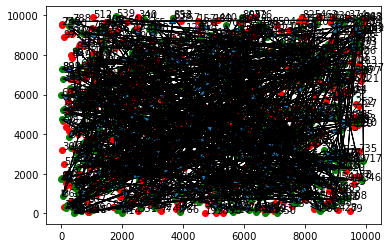

In [21]:
# Seed of generation
random.seed(a=5)

# Generator settings
nbPoints = 1000
Size_Map = (10000, 10000)
Fluctuation = 10
Fluctuation_Weight = 10

# Generation of cities
points = DefinitionCity(GeneratorCity(nbPoints, Size_Map))

# Generation of the graph
graph = GeneratorGraph(points, Fluctuation, Fluctuation_Weight)

start_time = time.time()
# Create a path with every cities which need to be delivered
cycle = []
for i in range(len(points)):
    if points[i][2] == 1:
        cycle += [i+1]
# Get the repository point
repository = [x+1 for x, y in enumerate(points) if y[2] == 2]
# Add the depository on the path
cycle = repository + cycle + repository

## Initiale solution
# Calculate the energie of the path
energie = EnergieSum(graph, cycle)
#print(energie)
#print(cycle)
# Initiate the first figure
#fig1, ax1 = plt.subplots()
#DisplayCycle(ax1, points, cycle)

## Improvement of the solution
cycle, energie = Recuit(graph, cycle, energie, nbPoints * 10000, 0.001, 0.999)

print("--- %s seconds ---" % (time.time() - start_time))
print("Time cost : %s." % EnergieSum(graph, cycle))
print("Cycle use : " + str(cycle) + ".")
# Initiate the second figure
fig2, ax2 = plt.subplots()
DisplayCycle(ax2, points, cycle)